In [1]:
import numpy as np
import random
import math
import itertools
import warnings
import pickle
import gc
import sys
import matplotlib.pyplot as plt
from os.path import join, exists
from collections import Counter, defaultdict
from scipy.special import gamma
from itertools import permutations, combinations, combinations_with_replacement, product
import timeit
import multiprocessing
import tqdm
import time
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.5f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Step 1: Load Beacon, MAF, Reference and other cached variables

In [2]:
# Replace it with the main folder
mainPath = "./data"
np.random.seed(2024)

In [3]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
%load_ext autoreload
%autoreload 2
from scripts.common.data import get_maf_values, pre_process_maf

# Extracting column to an array for future use
maf_values = get_maf_values(mainPath)
maf_values = pre_process_maf(maf_values)


In [4]:
maf_values

array([0.03300, 0.27400, 0.00100, ..., 0.19200, 0.45000, 0.16400])

#### Build beacons, control groups and select victim
Construct beacons and the victim. Here randomly select;
1. A single victim
2. 20 control group people for attacker to calculate LRT values
3. 20 control group people for sharer to calculate LRT values
4. 60 people beacon for sharer

In [5]:
from scripts.common.data import get_data


s_beacon, a_control, victims = get_data(mainPath, victims_in_beacon_count=20)

In [ ]:
print(f'Beacon size: {len(s_beacon.T)}')
print(f'Attacker control group size: {len(a_control.T)}')
print(f'Victims in beacon: {10}')

randomness_id = np.random.rand()
print(f'{randomness_id}')

Beacon size: 80
Attacker control group size: 40
Victims in beacon: 10
0.7973871717092873


### Step 2: Function definitions

#### Position based LRT calculation
First function calculates LRT value for given number of people in beacon, it's response, victim's genome and maf values

Second one calculates LRT valus for a single person and a given control group, then returns it

In [ ]:
from scripts.common.lrt import get_optimal_lrt_victim, get_optimal_lrt, p_value_ind, calculate_lrt

In [ ]:
# Testing
get_optimal_lrt_victim(-1, maf_values, a_control, np.array([1, 12]), np.array([0.5, 0.7]))

(3.3553171233220955,
 array([3.35532, 0.00000, 0.00000, 9.62266, 0.00000, 6.26734, 0.00000,
        0.00000, 3.35532, 9.62266, 9.62266, 9.62266, 9.62266, 3.35532,
        9.62266, 9.62266, 0.00000, 9.62266, 3.35532, 6.26734, 0.00000,
        3.35532, 3.35532, 9.62266, 3.35532, 9.62266, 0.00000, 9.62266,
        0.00000, 9.62266, 9.62266, 0.00000, 0.00000, 9.62266, 9.62266,
        9.62266, 3.35532, 3.35532, 9.62266]))

In [ ]:
# Testing
lrts =get_optimal_lrt(maf_values, a_control, np.array([1, 12]), np.array([0.5, 0.7]))
p_value_ind(lrts, -1)

0.5128205128205128

**Playground** (Do not run these stuff)

In [ ]:
# Testing
calculate_lrt(80, np.array([0.5,0.5,0.5,0.5,0.5]), np.array([1,1,1,1,1]), maf_values[A], np.array([True, True, True, True, True]))

In [ ]:
s_beacon[A].sum(axis=1)

In [ ]:
victims[A, -1]

In [ ]:
a_control[A, -1]

In [ ]:
utility_beacon.utility_sharer(a_grd, s_grd, 5 )[1]

In [ ]:
utility_attacker.utility_attacker(a_grd,s_grd, 5, -1)

## Utility Functions

**MAF Value:** <code>-np.log(maf.iloc[ai]["maf"]+1e-3)/abs(np.log(1e-3))</code> <br>
**Lying Probability:** <code>(1-si)</code><br>
**Number of Queries Sent:** <code>num_query/20</code><br>
**p-value change for donors:** <code>np.sum(p_prevs - p_currents)/len(p_prevs) </code><br>
**Count of risky people:** <code>np.sum(p_currents <= 0.05)/len(p_currents)</code><br>
**Deviation of p-values:** <code>np.std(p_currents)</code><br>

In [10]:
def sharer_u1(ai, si, p_prevs, p_currents, num_query, lrt_values):  
    q1 = np.quantile(lrt_values, 0.25)
    target_LRTs = lrt_values[lrt_values < q1]

    if len(target_LRTs) != 0:
        target_LRTs = np.append(target_LRTs, np.mean(lrt_values))
        target_LRTs = (target_LRTs - target_LRTs.min()) / (target_LRTs.max() - target_LRTs.min())
    
    mean = np.mean(target_LRTs)
    std_dev = np.std(target_LRTs, ddof=1)
    
    term_one = (1 - (std_dev / mean)) if mean != 0 and len(target_LRTs) != 0 else 1
    
    return (term_one * 5 + sum(si) / len(si)) / 6

In [11]:
def attacker_u1(ai, si, p_prev, p_current, num_query):
    utility = (p_current - p_prev)
    # print(f'* Attacker: ai: {ai}, si: {si}, p_prev: {p_prev}, p_current: {p_current}, num_query: {num_query} \n utility: {(utility+2) * 2/3}')
    return utility #normalize
    # return (utility+2) * 2/3 #normalize

In [12]:
# Utility Functions
afunc = attacker_u1
sfunc = sharer_u1

### Game Scenario

In [13]:
num_query = 4
possible_snps = 4
exist_count = 4
beacon_not_exist_count = 0

if (exist_count + beacon_not_exist_count > num_query):
    raise ValueError("check the values")

In [14]:
victim = victims[:, -1]

In [27]:
a_control[A, -1]

array([1, 1, 1, 1])

In [55]:
from scripts.common.utility import UtilityAttacker, UtilityBeacon


utility_attacker = UtilityAttacker(maf_values, a_control, afunc)
utility_beacon = UtilityBeacon(maf_values, s_beacon, sfunc)

In [44]:
# Find rare SNPs
A = np.random.choice(s_beacon.shape[0], possible_snps)
# 1- ensure that 
# 2- ensure that the selected SNPs are reliable. (They have a good MAF)
# 3- ensure that some SNPs, given their counts, do not exist at the beacon.
# 4- ensure that the SNPs not existing at the beacon exists at the attacker's control.
while np.sum(victim[A]) < exist_count or not maf_values[A].all() \
    or np.sum(maf_values[A]*victim[A]) >= 0.15*exist_count \
    or (num_query - s_beacon[A].any(axis=1).sum() < beacon_not_exist_count) \
    or num_query - a_control[A].any(axis=1).sum() > beacon_not_exist_count: 
    # print(np.sum(victim[A]))
    A = np.random.choice(s_beacon.shape[0], possible_snps)

In [16]:
from scripts.common.scenario import optimal_scenario

A = optimal_scenario(maf_values, num_query, victim)
print(A)
print(maf_values[A])
print(A[victim].sum())

[ 795051 3519123  192218 3747884]
[0.00400 0.00400 0.00400 0.00400]
5949199050144


In [45]:
#  Sharer's Strategy
S = np.round(np.arange(0.7, 1.01, 0.1), 2)
S = np.array([0.5, 0.7, 1, 0.25])

# Product Space
all_attacker = np.array(list(permutations(A, num_query)))
all_sharer = list(product(S, repeat=num_query))


# Utility Functions
afunc = attacker_u1
sfunc = sharer_u1

# Print Information
print("Will try at most ", len(all_attacker)*len(all_sharer), " iterations")
print(f"Not exsisting SNP index: {A[~s_beacon[A].any(axis=1)]}")
print("Victim: ", victim[A], "\nAttacker Strategy Set: ",
      A, "\nSharer Strategy Set: ", S, "\nMAF: ", maf_values[A])

Will try at most  6144  iterations
Not exsisting SNP index: []
Victim:  [1 1 1 1] 
Attacker Strategy Set:  [2048813 1606955   83121 2723535] 
Sharer Strategy Set:  [0.50000 0.70000 1.00000 0.25000] 
MAF:  [0.06400 0.07500 0.06800 0.25000]


## 1. Equilibrium

#### Disclaimer from kayoz@
This looks ugly and I wrote it long time ago. It is working perfectly fine but feel free to make it faster and more beautiful

Basically it traverses the whole game tree bottom-up to calculate which path leads to Nash Equilibrium

It's also multithreaded (as much as it can be in Python) so I suggest not to touch in below code if not necessary or if you are not crazy ambitious

In [20]:
import os
os.cpu_count()

40

In [56]:
%%time
import time

utilities = defaultdict(lambda: defaultdict(lambda: (0, 0)))
strategies = defaultdict(lambda: defaultdict(lambda: (0, 0)))


def func(params):
    a = params[0]  # strategy sets of Attacker
    s = params[1]  # strategy sets of Sharer
    # print(f"{a}, {s}")
    # utility of sharer
    us = np.array([
        np.array([
            utility_beacon.utility_sharer(np.append(a, ai), np.append(s, si), i)[0][-1] + utilities[a+(ai,)][s+(si,)][1] if ai not in a else -np.inf for si in S]) for ai in A
    ])
    # Optimum sharer strategy
    os = np.argmax(us, axis=1)
    bus = np.choose(os, us.T)

    # Find optimum strategy for all possible ai
    ua = np.array([utility_attacker.utility_attacker(np.append(a, ai), np.append(s, S[os[t]]), i, -1)[0][-1] +
                  utilities[a+(ai,)][s+(S[os[t]],)][0] if ai not in a else -np.inf for t, ai in enumerate(A)])
    oa = np.argmax(ua)
    bua = ua[oa]
    return a, s, A[oa], S[os[oa]], bua, bus[oa]


i = num_query
times = []
while i > 1:
    start = time.time()

    # Generate all possible past strategy combinations
    all_attacker = list(permutations(A, i-1))
    all_sharer = list(product(S, repeat=i-1))
    print(f'i is {i}')

    #  Param grid for multiprocessor pool unit
    paramlist = list(product(all_attacker, all_sharer))
    print('params are generated!')
    pool = multiprocessing.Pool(39)

    try:
        res  = pool.map(func,paramlist)
        print('Started all sub processes')
        for r in res:
            strategies[r[0]][r[1]] = (r[2], r[3])
            utilities[r[0]][r[1]] = (r[4], r[5])
        i-=1

    except:
        print("Something went wrong. Killing all of the processes")
        pool.terminate()
        break

    finally:
        print('iteration is over. Killing child processes')
        pool.close()
        pool.join()

        end = time.time()
        elapsed_time = end - start
        print(f'Time for {i} is {elapsed_time}')
        times.append(elapsed_time)

    # print(f'Running with params {paramlist[0]}')
    # test_x = func(paramlist[0])
    # break

i is 4
params are generated!


Started all sub processes
iteration is over. Killing child processes
Time for 3 is 13.39495587348938
i is 3
params are generated!
Started all sub processes
iteration is over. Killing child processes
Time for 2 is 4.775117874145508
i is 2
params are generated!
Started all sub processes
iteration is over. Killing child processes
Time for 1 is 3.0468318462371826
CPU times: user 331 ms, sys: 7.52 s, total: 7.85 s
Wall time: 21.2 s


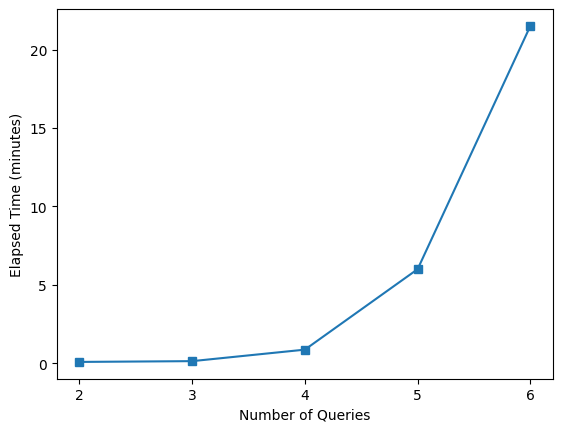

In [ ]:
plt.xlabel("Number of Queries")
plt.ylabel("Elapsed Time (minutes)")
plt.xticks(np.arange(0, 7))
plt.plot(np.arange(2, 7), np.round(np.array(times[::-1])) / 60, '-s')
plt.savefig("output.png")

In [ ]:
plt.xlabel("Number of Queries")
plt.ylabel("Elapsed time (log of seconds)")
plt.xticks(np.arange(0, 7))
plt.plot(np.arange(2, 7), np.log(np.array(times[::-1])), '-s')
plt.savefig("output.png")

In [ ]:
for key_one in dict.keys(utilities):
    # if (len(key_one) <= 1): break
    for key_two in dict.keys(utilities[key_one]):
        # print(f"{key_one}, {key_two}")
        # print(utilities[key_one][key_two])
        if utilities[key_one][key_two][0] != 0:
            print(f"{key_one}, {key_two}")
            print(utilities[key_one][key_two])
        
        

In [ ]:
test_x

((2933264, 2039982), (0.5, 0.5), 3174731, 1.0, 0.0, 0.2222222222222222)

In [57]:
# Final step, first query
us = np.array([np.array([utility_beacon.utility_sharer(np.array([ai]), np.array([si]), i)[0][-1] + utilities[tuple([ai])][tuple([si])][1] for si in S]) for ai in A])
os = np.argmax(us, axis=1)  
bus = np.choose(os, us.T)

# Find optimum strategy for all possible ai
ua = np.array([utility_attacker.utility_attacker(np.array([ai]), np.array([S[os[t]]]), i, -1)[0][-1] + utilities[tuple([ai])][tuple([S[os[t]]])][0] for t, ai in enumerate(A)])
oa = np.argmax(ua)
bua = ua[oa]
    
# Finally
a_eq = np.array([A[oa]])
s_eq = np.array([S[os[oa]]])
for i in range(num_query-1):
    a, s = strategies[tuple(a_eq)][tuple(s_eq)]
    a_eq = np.append(a_eq, a, axis=None)
    s_eq = np.append(s_eq, s, axis=None)
    

au_eq = np.zeros((num_query+1))
su_eq = np.zeros((num_query+1))
for i in range(num_query-1, 0, -1):
    au_eq[i+1], su_eq[i+1] = np.array(utilities[tuple(a_eq[:i])][tuple(s_eq[:i])]) - np.array(utilities[tuple(a_eq[:i+1])][tuple(s_eq[:i+1])])
au_eq[1] = bua - np.array(utilities[tuple(a_eq[:1])][tuple(s_eq[:1])])[0]
su_eq[1] = bus[oa] - np.array(utilities[tuple(a_eq[:1])][tuple(s_eq[:1])])[1]

## 2. Greedy

In [58]:
a_grd = s_grd = np.array([], dtype=int)
au_grd = np.zeros((num_query+1))
su_grd = np.zeros((num_query+1))

for i in range(num_query):
    # Final step, first query
    us = np.array([np.array([utility_beacon.utility_sharer(np.append(a_grd, ai), np.append(s_grd, si), i+1)[0][-1] if ai not in a_grd else -np.inf for si in S]) for ai in A])
    os = np.argmax(us, axis=1)  
    bus = np.choose(os, us.T)

    # Find optimum strategy for all possible ai
    ua = np.array([utility_attacker.utility_attacker(np.append(a_grd, ai), np.append(s_grd, S[os[t]]), i+1, -1)[0][-1] if ai not in a_grd else -np.inf for t, ai in enumerate(A)])
    oa = np.argmax(ua)
    bua = ua[oa]

    # Obtain best strategies
    a_grd = np.append(a_grd, A[oa])
    s_grd = np.append(s_grd, S[os[oa]])
    
    # Obtain utilities for the step i
    au_grd[i+1], su_grd[i+1] = (bua, bus[oa])
    
    print("A: ", a_grd, "\nS: ", s_grd)
    print("Utilities: ", au_grd[i+1], su_grd[i+1], "\n")

A:  [2723535] 
S:  [1.00000]
Utilities:  0.7435897435897436 1.0 

A:  [2723535 2048813] 
S:  [1.00000 0.70000]
Utilities:  -0.6410256410256411 0.975 

A:  [2723535 2048813 1606955] 
S:  [1.00000 0.70000 0.70000]
Utilities:  -0.07692307692307687 0.9666666666666667 

A:  [2723535 2048813 1606955   83121] 
S:  [1.00000 0.70000 0.70000 0.70000]
Utilities:  -0.02564102564102566 0.9625 



## 3. Optimal Attack

In [85]:
def get_beacon_LRT(lrts, title):
    plt.figure()
    plt.title(title)
    plt.xlabel("Number of Queries")
    plt.ylabel("LRT")
    # plt.ylim([-7, 7])
    plt.xticks(np.arange(0, lrts.shape[1] + 1, 1.0))
    # Plot each user's data as a separate line
    for i in range(lrts.shape[0]):
        if (i == lrts.shape[0]-1):
            plt.plot(lrts[i, :], '-o', label="victim")
            continue
            
        plt.plot(lrts[i, :])

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

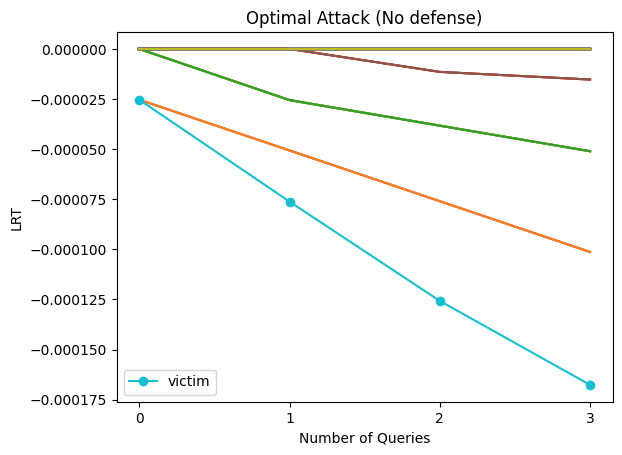

In [86]:
# Optimal Attack
a_opt = A[np.argsort(maf_values[A])][:num_query]
s_opt = np.ones(num_query)

_, pv_opt = utility_attacker.utility_attacker(a_opt, s_opt, num_query, -1)
_, lrts = utility_beacon.utility_sharer(a_opt, s_opt, len(s_opt))
get_beacon_LRT(lrts.T, 'Optimal Attack (No defense)')

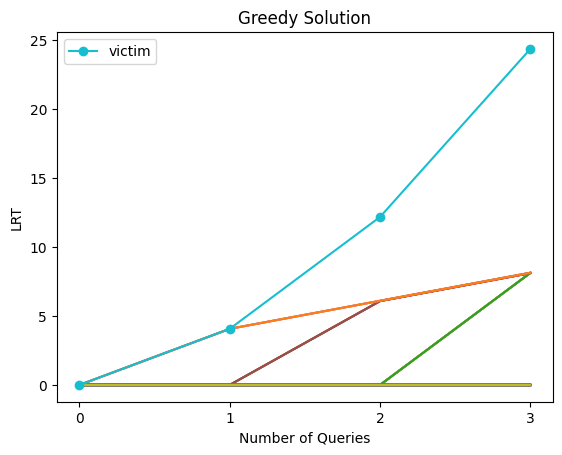

In [87]:
_, lrts = utility_beacon.utility_sharer(a_grd, s_grd, len(s_opt))
get_beacon_LRT(lrts.T, 'Greedy Solution')

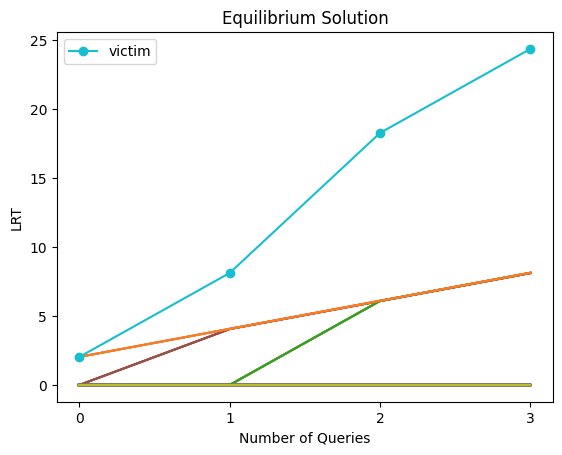

In [88]:
_, lrts = utility_beacon.utility_sharer(a_eq, s_eq, len(s_opt))
get_beacon_LRT(lrts.T, 'Equilibrium Solution')

In [64]:
_, pv_grd = utility_attacker.utility_attacker(a_grd, s_grd, num_query, -1)
_, pv_eq = utility_attacker.utility_attacker(a_eq, s_eq, num_query, -1)

# Plot

In [82]:
def fix_pvalue_bug(pv):
    tmp = np.ones(pv.shape[0] + 1)
    tmp[1:] = 1 - pv
    return tmp
    

def create_plot(ax,title,au,su,a,s, pv):
    pv = fix_pvalue_bug(pv)
    ax.title.set_text(title)
    ax.plot(au, label="Attacker")
    ax.plot(su, label="Sharer")
    
    #ax.plot(np.cumsum(au), label="Attacker Cumulative")
    #ax.plot(np.cumsum(su), label="Sharer Cumulative")
    
    ax.plot(pv,'--bo', color='tab:red', label='p-victim')

    ax.set_ylabel("Utility")
    ax.set_xticks(np.arange(num_query+1), [])  
    ax.legend()
    ax.grid(True)
    ax.get_xaxis().set_visible(False)
    # P-value plot

    columns = tuple([str(i) for i in range(num_query+1)])
    
    rows = ('Victim', 'MAF', 'Indices', 'Sharer')
    # rows = ('Victim', 'Indices', 'Sharer')
    victim_representaion = ["✓ " if item  else "✘" for item in victim[a]]
    # print(victim_representaion)
    cells = np.hstack([np.zeros((4,1))+np.inf, np.vstack([victim_representaion,np.round(maf_values[a],3),a, s])])
    # cells = np.hstack([np.zeros((4,1))+np.inf, np.vstack([victim_representaion, a , s* 100])])
    the_table = plt.table(cellText=cells,rowLabels=rows,colLabels=columns,loc='bottom')
    return ax

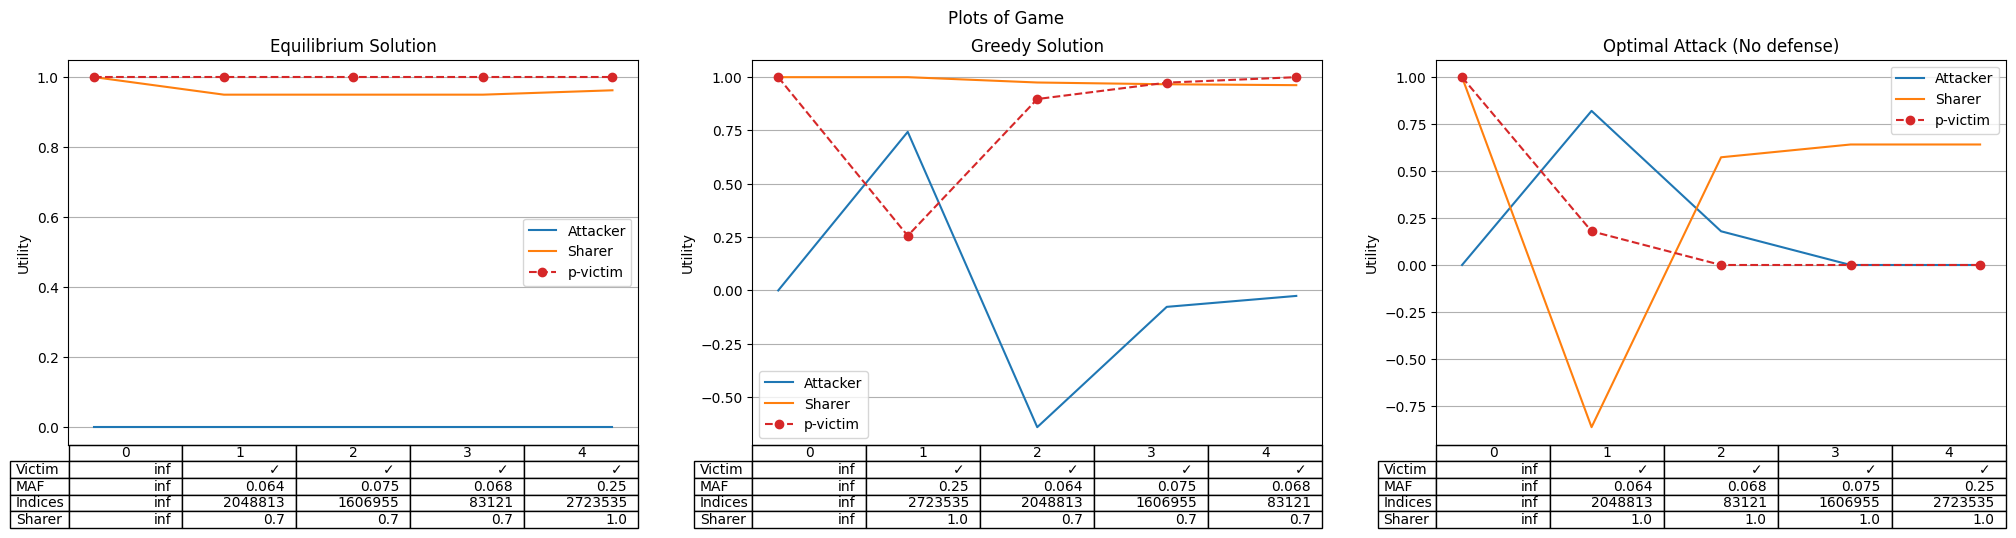

In [84]:
fig = plt.figure(figsize=(25, 5))
su_eq[0], su_grd[0], su_opt[0] = 1, 1, 1

# Figure 1
ax1 = fig.add_subplot(131)
ax1 = create_plot(ax1,"Equilibrium Solution",au_eq,su_eq,a_eq,s_eq, pv_eq)

# Figure 2
ax2 = fig.add_subplot(132)
ax2 = create_plot(ax2,"Greedy Solution",au_grd,su_grd,a_grd,s_grd, pv_grd)

# Figure 3
ax3 = fig.add_subplot(133)
ax3 = create_plot(ax3,"Optimal Attack (No defense)",au_opt,su_opt,a_opt,s_opt, pv_opt)

fig.suptitle('Plots of Game')
plt.show()
#fig.savefig("6queery3.png", dpi=500, bbox_inches="tight", pad_inches=1)

In [86]:
# s_beacon[795051].sum()
s_beacon[A].sum(axis=1)

array([1, 1, 1, 2, 1])

In [87]:
A

array([ 795051, 3519123,  192218, 3747884, 1946643])

## LRT Experiments

In [ ]:
error=0.001
def calculate_lrt(num_people, response, genome, maf):
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    # Genome == 1
    log1 = np.log(DN_i/(error*DN_i_1))
    log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))
    
    # Genome == 0
    log3 = np.log(DN_i)-np.log(((1-error)*DN_i_1))
    log4 = np.log(1-error) + np.log(DN_i_1) + np.log(1-DN_i) - (    np.log(DN_i) + np.log(1-DN_i_1*(1-error))    )  
    print("Log1: ", log1, "\nLog2: ", log2, "\nLog3: ", log3, "\nLog4: ", log4, "\n\n")
    return  (log1+log2*response) * genome.T + (log3+log4*response) * (1-genome).T

temp = calculate_lrt(60, np.array([0,0,1,1]), np.array([0,1,0,1]), np.array([0.15]*4))

print("Optimal Attack - LRT Values in Attacker's Side")
print("Case where MAF=0.001 and beacon response and genome value is accordingly\n-------------------------------------------------------")
print("Response=0 & Genome=0 --> ", temp[0])
print("Response=0 & Genome=1 --> ", temp[1])
print("Response=1 & Genome=0 --> ", temp[2])
print("Response=1 & Genome=1 --> ", temp[3])

In [ ]:
temp = calculate_lrt(60, np.array([0,1,0,1]), np.array([0,0,1,1]), np.array([0.001,0.001,0.001,0.001]))
print("Optimal Attack - LRT Values in Defender's Side")
print("Case where MAF=0.001 and beacon response and genome value is accordingly\n-------------------------------------------------------")
print("Response=0 & Genome=0 --> ", temp[0])
print("Response=0 & Genome=1 --> NOT VALID")#, temp[1])
print("Response=1 & Genome=0 --> ", temp[2])
print("Response=1 & Genome=1 --> ", temp[3])